# Random Forest
Equus, bowtie, transcripts.

Use the validation data used in RF_155
but analyze it with the model from RF_147.

In [15]:
from datetime import datetime
print(datetime.now())

2023-11-21 00:48:43.701710


In [16]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/IRP2/Equus/Bowtie/validation/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/IRP2/Equus/Bowtie/'  # must end in "/"
except:
    IN_COLAB = False
    print('Running on Mac')
    DATA_DIR="Equus/Bowtie/validation"
    MODEL_DIR="Equus/Bowtie/"
SAVE_MODEL_FILENAME = None

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [17]:
from platform import python_version
print('Python',python_version())
import random
import numpy as np
np.random.seed(42) # supposedly sets scikit-learn
import pandas as pd  # for plotting
import time # sleep function
from os.path import isfile
import gzip
from matplotlib import pyplot as plt
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)
import joblib # save & load scikit-learn models

from tensorflow import keras
# consider sklearn.metrics.classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RFC

EPOCHS=150

Python 3.10.12
sklearn 1.2.2


## Data Load

In [18]:
#MAX_LINES_TO_LOAD =    1000000 # training - 1M lines requires 2GB RAM
#MAX_LINES_TO_LOAD =    10000 # use this for debugging
MAX_LINES_TO_LOAD =    2000000

VALID_PORTION = 0.20

DATA_FILE_0 = 'filtered.asinus_read_stats.csv.gz'
DATA_FILE_1 = 'filtered.caballus_read_stats.csv.gz'
MODEL_FILE = 'RF_147.joblib'  # input

print('Data directory: %s'%DATA_DIR)
print('Data file 0 %s'%DATA_FILE_0)
print('Data file 1 %s'%DATA_FILE_1)
print('Input lines for training: %d'%MAX_LINES_TO_LOAD)
print('Model directory: %s'%MODEL_DIR)
print('Model file: %s'%MODEL_FILE)

Data directory: /content/drive/My Drive/data/IRP2/Equus/Bowtie/validation/
Data file 0 filtered.asinus_read_stats.csv.gz
Data file 1 filtered.caballus_read_stats.csv.gz
Input lines for training: 2000000
Model directory: /content/drive/My Drive/data/IRP2/Equus/Bowtie/
Model file: RF_147.joblib


In [19]:
# P1 parent 1
# R1 read 1
# PS primary or secondary
# AS bowtie alignment score (0 is best)
# ED edit distance
# MM mismatch count
# GO gap open count
# GE gap extend count
feature_names = [
    'P1 R1 AS',
    'P1 R1 ED',
    ##'P1 R1 MAT',
    'P1 R1 MM',
    'P1 R1 HQMM',
    'P1 R1 GO',
    'P1 R1 GE',
    'P1 R1 INS',
    'P1 R1 DELS',
    'P1 R1 HQINS',
    'P1 R1 HQDEL',
    'P1 R2 AS',
    'P1 R2 ED',
    ##'P1 R2 MAT',
    'P1 R2 MM',
    'P1 R2 HQMM',
    'P1 R2 GO',
    'P1 R2 GE',
    'P1 R2 INS',
    'P1 R2 DELS',
    'P1 R2 HQINS',
    'P1 R2 HQDEL',
    'P2 R1 AS',
    'P2 R1 ED',
    ##'P2 R1 MAT',
    'P2 R1 MM',
    'P2 R1 HQMM',
    'P2 R1 GO',
    'P2 R1 GE',
    'P2 R1 INS',
    'P2 R1 DELS',
    'P2 R1 HQINS',
    'P2 R1 HQDEL',
    'P2 R2 AS',
    'P2 R2 ED',
    ##'P2 R2 MAT',
    'P2 R2 MM',
    'P2 R2 HQMM',
    'P2 R2 GO',
    'P2 R2 GE',
    'P2 R2 INS',
    'P2 R2 DELS',
    'P2 R2 HQINS',
    'P2 R2 HQDEL',
    ##'R1 length',
    ##'R2 length',
    ##'P1 span',
    ##'P2 span',
    'Span diff',
    'AS diff',
    'ED diff',
    'MAT diff',
    'MM diff',
    'HQMM diff',
    'GO diff',
    'GE diff',
    'INS diff',
    'DELS diff',
    'HQINS diff',
    'HQDEL diff',
    'PARENT']
print('Total feature names: ',len(feature_names))
for i in range(len(feature_names)):
    print(i,feature_names[i])

Total feature names:  53
0 P1 R1 AS
1 P1 R1 ED
2 P1 R1 MM
3 P1 R1 HQMM
4 P1 R1 GO
5 P1 R1 GE
6 P1 R1 INS
7 P1 R1 DELS
8 P1 R1 HQINS
9 P1 R1 HQDEL
10 P1 R2 AS
11 P1 R2 ED
12 P1 R2 MM
13 P1 R2 HQMM
14 P1 R2 GO
15 P1 R2 GE
16 P1 R2 INS
17 P1 R2 DELS
18 P1 R2 HQINS
19 P1 R2 HQDEL
20 P2 R1 AS
21 P2 R1 ED
22 P2 R1 MM
23 P2 R1 HQMM
24 P2 R1 GO
25 P2 R1 GE
26 P2 R1 INS
27 P2 R1 DELS
28 P2 R1 HQINS
29 P2 R1 HQDEL
30 P2 R2 AS
31 P2 R2 ED
32 P2 R2 MM
33 P2 R2 HQMM
34 P2 R2 GO
35 P2 R2 GE
36 P2 R2 INS
37 P2 R2 DELS
38 P2 R2 HQINS
39 P2 R2 HQDEL
40 Span diff
41 AS diff
42 ED diff
43 MAT diff
44 MM diff
45 HQMM diff
46 GO diff
47 GE diff
48 INS diff
49 DELS diff
50 HQINS diff
51 HQDEL diff
52 PARENT


In [20]:
class DataLoader():
    def __init__(self,filepath1,filepath2,verbose=True):
        self.files = [filepath1,filepath2]
        self.alignments=[]
        self.labels=[]
        self.verbose = verbose
        self.max_lines = None
        self.ties = 0
        self.predictions = []
        self.num_features = 1

    def set_num_features(self,count):
        self.num_features = count

    def set_max_lines(self,lines):
        '''Limit the dataset size to fit in RAM.'''
        self.max_lines = lines
        if self.verbose:
            print('Maximum lines to load per file: %d'%lines)

    def _count_lines_(self):
        '''Show number of lines per input file.'''
        count0 = 0
        with gzip.open (self.files[0],'rt') as handle0:
            for row in handle0:
                count0 += 1
        count1 = 0
        with gzip.open(self.files[1],'rt') as handle1:
            for row in handle1:
                count1 += 1
        minimum = min(count0,count1)
        if self.verbose:
            print('File0 size: %d %s'%(count0,self.files[0]))
            print('File1 size: %d %s'%(count1,self.files[1]))
        return minimum

    def _load_line_(self,row):
        '''Load data structure from one line of CSV file.'''
        line = row.strip()
        fields = line.split(',')
        ints = [0] * self.num_features
        # These fields come straight from the input file.
        # These fields are grouped by which read they describe.
        # P1 R1 = Parent 1, Read 1
        ints[0] = int(fields[0]) # P1 R1 AS
        ints[1] = int(fields[1]) # P1 R1 ED
        P1R1_MAT = int(fields[2]) # P1 R1 MAT
        ints[2] = int(fields[3]) # P1 R1 MM
        ints[3] = int(fields[4]) # P1 R1 HQMM
        ints[4] = int(fields[5]) # P1 R1 GO
        ints[5] = int(fields[6]) # P1 R1 GE
        ints[6] = int(fields[7]) # P1 R1 INS
        ints[7] = int(fields[8]) # P1 R1 DELS
        ints[8] = int(fields[9]) # P1 R1 HQINS
        ints[9] = int(fields[10]) # P1 R1 HQDEL
        #  = Parent 1, Read 2
        ints[10] = int(fields[11]) # P1 R2 AS
        ints[11] = int(fields[12]) # P1 R2 ED
        P1R2_MAT = int(fields[13]) # P1 R2 MAT
        ints[12] = int(fields[14]) # P1 R2 MM
        ints[13] = int(fields[15]) # P1 R2 HQMM
        ints[14] = int(fields[16]) # P1 R2 GO
        ints[15] = int(fields[17]) # P1 R2 GE
        ints[16] = int(fields[18]) # P1 R2 INS
        ints[17] = int(fields[19]) # P1 R2 DELS
        ints[18] = int(fields[20]) # P1 R2 HQINS
        ints[19] = int(fields[21]) # P1 R2 HQDEL
        # P2 R1 = Parent 2, Read 1
        ints[20] = int(fields[22]) # P2 R1 AS
        ints[21] = int(fields[23]) # P2 R1 ED
        P2R1_MAT = int(fields[24]) # P2 R1 MAT
        ints[22] = int(fields[25]) # P2 R1 MM
        ints[23] = int(fields[26]) # P2 R1 HQMM
        ints[24] = int(fields[27]) # P2 R1 GO
        ints[25] = int(fields[28]) # P2 R1 GE
        ints[26] = int(fields[29]) # P2 R1 INS
        ints[27] = int(fields[30]) # P2 R1 DELS
        ints[28] = int(fields[31]) # P2 R1 HQINS
        ints[29] = int(fields[32]) # P2 R1 HQDEL
        # P2 R2 = Parent 2, Read 2
        ints[30] = int(fields[33]) # P2 R2 AS
        ints[31] = int(fields[34]) # P2 R2 ED
        P2R2_MAT = int(fields[35]) # P2 R2 MAT
        ints[32] = int(fields[36]) # P2 R2 MM
        ints[33] = int(fields[37]) # P2 R2 HQMM
        ints[34] = int(fields[38]) # P2 R2 GO
        ints[35] = int(fields[39]) # P2 R2 GE
        ints[36] = int(fields[40]) # P2 R2 INS
        ints[37] = int(fields[41]) # P2 R2 DELS
        ints[38] = int(fields[42]) # P2 R2 HQINS
        ints[39] = int(fields[43]) # P2 R2 HQDEL
        # Fields that come in twos
        R1_LEN = int(fields[44]) # R1 length (of read)
        R2_LEN = int(fields[45]) # R2 length (of read)
        P1_SPAN = int(fields[46]) # P1 span (of mapped read pair)
        P2_SPAN = int(fields[47]) # P2 span (of mapped read pair)
        # Read-wise differences
        ints[40] = P2_SPAN-P1_SPAN # P2-P1 span diff
        ints[41] = (ints[33]+ints[22])-(ints[11]+ints[0]) # AS diff
        ints[42] = (ints[34]+ints[23])-(ints[12]+ints[1]) # ED diff
        ints[43] = (P2R1_MAT+P2R2_MAT)-(P1R1_MAT+P1R2_MAT) # MAT diff
        ints[44] = (ints[36]+ints[25])-(ints[14]+ints[3]) # MM diff
        ints[45] = (ints[37]+ints[26])-(ints[15]+ints[4]) # HQMM diff
        ints[46] = (ints[38]+ints[27])-(ints[16]+ints[5]) # GO diff
        ints[47] = (ints[39]+ints[28])-(ints[17]+ints[6]) # GE diff
        ints[48] = (ints[40]+ints[29])-(ints[18]+ints[7]) # INS diff
        ints[49] = (ints[41]+ints[30])-(ints[19]+ints[8]) # DELS diff
        ints[50] = (ints[42]+ints[31])-(ints[20]+ints[9]) # HQINS diff
        ints[51] = (ints[43]+ints[32])-(ints[21]+ints[10]) # HQDEL diff
        # The feature-extraction program populated a field
        # to indicate which parent had higher alignment score.
        # Values were 0=same, 1=parent1, 2=parent2.
        # We change the values to -1=parent1, 0=unknown, +1=parent2
        parent_choice = int(fields[48])
        if parent_choice == 1:
            ints[52] = -1  # not parent 2
        elif parent_choice == 2:
            ints[52] = 1  # is parent 2
        elif parent_choice == 0:
            ints[52] = 0
        else:
            raise Exception('Unrecognized parent choice:'+str(parent_choice))
        # For fair comparison, force aligner to choose.
        # We change 1 to 0, 2 to 1, and 0 to 1 or 2 randomly.
        # TO DO: faster alternative to list.append() ???
        parent_choice = int(fields[48])
        if parent_choice == 1:
            self.predictions.append(0)  # not parent 2
        elif parent_choice == 2:
            self.predictions.append(1)  # is parent 2
        else: # parent_choice == 0:
            self.ties += 1
            guess = random.randint(0,1)
            self.predictions.append(guess)
        # The transcript that this read pair aligned to.
        # This is for pipelines that only process reads that map
        # to same transcript in both parents and (filter the others).
        # Pipelines that assign reads to parent, regardless of which gene,
        # should ignore this value. (It only reflects first parent map anyway.)
        transcript_id = fields[49] # TO DO: where to put this?
        self.alignments.append(ints)

    def count_ties(self):
        return self.ties

    def load_full_train_set(self):
        '''Load full train set (to be used for train and valiation).
           Use set_max_lines() to leave some data for the test set.'''
        minimum = 0
        train_size = self.max_lines
        if self.verbose:
            print('Trying to load %d lines per file...'%train_size)
        try:
            handle0 = gzip.open(self.files[0],'rt')
            handle1 = gzip.open(self.files[1],'rt')
            # Associate label 0 with data from file 0. Same for 1.
            for i in range(train_size):
                row = next(handle0)
                self._load_line_(row)
                self.labels.append(0)
                row = next(handle1)
                self._load_line_(row)
                self.labels.append(1)
            handle0.close()
            handle1.close()
        except Exception as e:
            print(e)
            print('Most likely, one file has too few reads.')
            raise Exception('CANNOT LOAD DATA FROM FILE!')

    def show_examples(self,head=6):
        head = min(head,len(self.alignments))
        for i in range(head):
            print('From '+self.files[self.labels[i]])
            print('Score,Edit,MM,HQMM,GapOpen,GapExtend,INS,DELS,HQINS,HQDEL')
            print(self.alignments[i][0:9])
            print(self.alignments[i][10:19])
            print(self.alignments[i][20:29])
            print(self.alignments[i][30:39])
            print('Parent choice:',self.alignments[i][52])

    def get_X_y(self):
        loaded = len(self.alignments)
        divider = int(loaded - loaded * VALID_PORTION)
        X_train = np.array(self.alignments[:divider])
        y_train = np.array(self.labels[:divider])
        X_valid = np.array(self.alignments[divider:])
        y_valid = np.array(self.labels[divider:])
        if self.verbose:
            print('Full train set size = '+str(len(self.alignments)))
            print('Training/Validation partition: %d/%d'%(len(y_train),len(y_valid)))
        return X_train,y_train, X_valid,y_valid

    def get_predictions(self):
        loaded = len(self.predictions)
        divider = int(loaded - loaded * VALID_PORTION)
        y_train = self.predictions[:divider]
        y_valid = self.predictions[divider:]
        return y_train, y_valid

In [21]:
print(datetime.now())
filepath0 = DATA_DIR+DATA_FILE_0
filepath1 = DATA_DIR+DATA_FILE_1
loader=DataLoader(filepath0,filepath1)
loader.set_max_lines(MAX_LINES_TO_LOAD)
loader.set_num_features(len(feature_names))
print('LOADING')
loader.load_full_train_set()
print('Number of ties: %d' % loader.count_ties())
aligner_predictions_train, aligner_predictions_valid = loader.get_predictions()
print(datetime.now())
loader.show_examples()

2023-11-21 00:48:45.223417
Maximum lines to load per file: 2000000
LOADING
Trying to load 2000000 lines per file...
Number of ties: 1627180
2023-11-21 00:50:09.428769
From /content/drive/My Drive/data/IRP2/Equus/Bowtie/validation/filtered.asinus_read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExtend,INS,DELS,HQINS,HQDEL
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
Parent choice: 0
From /content/drive/My Drive/data/IRP2/Equus/Bowtie/validation/filtered.caballus_read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExtend,INS,DELS,HQINS,HQDEL
[-6, 2, 2, 1, 0, 0, 0, 0, 0]
[-5, 1, 1, 1, 0, 0, 0, 0, 0]
[-1, 1, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
Parent choice: 1
From /content/drive/My Drive/data/IRP2/Equus/Bowtie/validation/filtered.asinus_read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExtend,INS,DELS,HQINS,HQDEL
[-5, 1, 1, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[-5, 1, 1, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 

In [22]:
X_train,y_train, X_valid,y_valid = loader.get_X_y()
print('X train shape: ')
print(np.shape(X_train))
print('y train shape: ')
print(np.shape(y_train))
print('X valid shape: ')
print(np.shape(X_valid))
print('y valid shape: ')
print(np.shape(y_valid))
print('X[5]=')
print(X_train[5])
print('y[5]=')
print(y_train[5])
#loader = None

Full train set size = 4000000
Training/Validation partition: 3200000/800000
X train shape: 
(3200000, 53)
y train shape: 
(3200000,)
X valid shape: 
(800000, 53)
y valid shape: 
(800000,)
X[5]=
[-6  2  2  1  0  0  0  0  0  0 -5  1  1  1  0  0  0  0  0  0 -1  1  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6 -3  2 -1  0  0  0
  0  6 -2  6  1]
y[5]=
1


## Model

In [23]:
# assume model was trained and saved with
## joblib.dump(rfc_model, MODEL_DIR+MODEL_FILE)
def build_model():
    filename = MODEL_DIR+MODEL_FILE
    print('Load this file')
    print(filename)
    rfc = joblib.load(filename)
    return rfc

In [24]:
print(datetime.now())
print('Use a model that was saved earlier.')
rfc_model=build_model()
print(rfc_model)

2023-11-21 00:50:32.715204
Use a model that was saved earlier.
Load this file
/content/drive/My Drive/data/IRP2/Equus/Bowtie/RF_147.joblib
RandomForestClassifier()


## Training

In [25]:
print(datetime.now())
print('Do not retrain the model.')

2023-11-21 00:50:41.834024
Do not retrain the model.


## Validation

In [26]:
print(datetime.now())
print("PREDICT")
yhat_classes=rfc_model.predict(X_valid)  # 0 or 1
yhat_pairs=rfc_model.predict_proba(X_valid)  # [ prob of 0, prob of 1 ]
yhat_pred=[pair[1] for pair in yhat_pairs]

print('debug pred',yhat_pred[:3])
print('debug class',yhat_classes[:3])
print(datetime.now())

2023-11-21 00:50:41.850401
PREDICT
debug pred [0.0036949990077249297, 0.9819621702335526, 0.546616938861678]
debug class [0 1 1]
2023-11-21 00:51:21.122368


In [27]:
# docs: Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.
def show_performance(y_valid, yhat_classes, yhat_pred):
    accuracy = accuracy_score(y_valid, yhat_classes)*100.
    precision = precision_score(y_valid, yhat_classes)*100.
    recall = recall_score(y_valid, yhat_classes)*100.
    sensitivity = recall_score(y_valid, yhat_classes, pos_label=1)*100.
    specificity = recall_score(y_valid, yhat_classes, pos_label=0)*100.
    f1 = f1_score(y_valid, yhat_classes)*100.
    mcc = matthews_corrcoef(y_valid, yhat_classes)
    if yhat_pred is None:
        # these stats are possible for probabilistic models only
        auprc = 0.
        auroc = 0.
    else:
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_valid, yhat_pred)*100.
    values,counts=np.unique(yhat_classes, return_counts=True)
    print('Predictions: ', dict(zip(values, counts)))
    print('Accuracy: %.2f%% F1: %.2f%% MCC: %.4f' % (accuracy,f1,mcc))
    print('Precision: %.2f%% Recall: %.2f%% AUPRC: %.2f%%' % (precision,recall,auprc))
    print('Sensitivity: %.2f%% Specificity: %.2f%% AUROC: %.2f%%' % (sensitivity,specificity,auroc))


In [28]:
print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
cm1 = confusion_matrix(y_valid,yhat_classes)
print('Confusion matrix\n',cm1)
cm2 = confusion_matrix(y_valid,yhat_classes,normalize='all')
print('Normalized matrix\n',cm2)

show_performance(y_valid, yhat_classes, yhat_pred)

Distrib of scores: 0.48512870500032673 mean 0.3658742414808942 std
Range of scores: 0.0 to 1.0
Confusion matrix
 [[294044 105956]
 [ 34595 365405]]
Normalized matrix
 [[0.367555   0.132445  ]
 [0.04324375 0.45675625]]
Predictions:  {0: 328639, 1: 471361}
Accuracy: 82.43% F1: 83.87% MCC: 0.6592
Precision: 77.52% Recall: 91.35% AUPRC: 91.75%
Sensitivity: 91.35% Specificity: 73.51% AUROC: 91.34%


## Comparison

In [29]:
show_performance(y_valid, aligner_predictions_valid, None)

Predictions:  {0: 421856, 1: 378144}
Accuracy: 75.86% F1: 75.18% MCC: 0.5179
Precision: 77.35% Recall: 73.12% AUPRC: 0.00%
Sensitivity: 73.12% Specificity: 78.59% AUROC: 0.00%


## Feature Importance

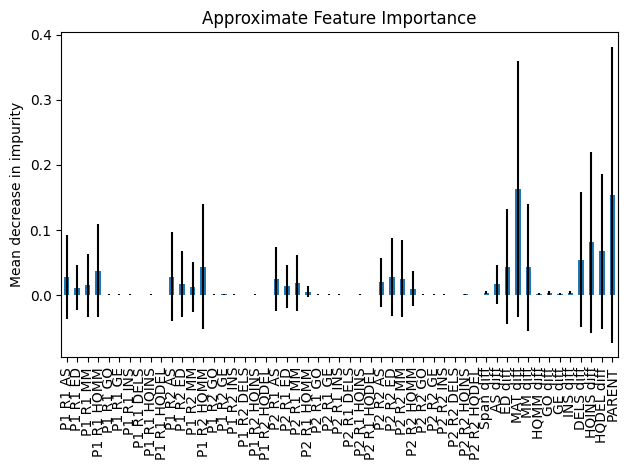

In [30]:
importances = rfc_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Approximate Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [31]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(forest_importances)

P1 R1 AS       0.027760
P1 R1 ED       0.011921
P1 R1 MM       0.015050
P1 R1 HQMM     0.037951
P1 R1 GO       0.000990
P1 R1 GE       0.001182
P1 R1 INS      0.000928
P1 R1 DELS     0.000350
P1 R1 HQINS    0.000827
P1 R1 HQDEL    0.000320
P1 R2 AS       0.028796
P1 R2 ED       0.017522
P1 R2 MM       0.012145
P1 R2 HQMM     0.043940
P1 R2 GO       0.000897
P1 R2 GE       0.001419
P1 R2 INS      0.000802
P1 R2 DELS     0.000334
P1 R2 HQINS    0.000870
P1 R2 HQDEL    0.000351
P2 R1 AS       0.024404
P2 R1 ED       0.013599
P2 R1 MM       0.018621
P2 R1 HQMM     0.005763
P2 R1 GO       0.000800
P2 R1 GE       0.001009
P2 R1 INS      0.000841
P2 R1 DELS     0.000279
P2 R1 HQINS    0.001045
P2 R1 HQDEL    0.000257
P2 R2 AS       0.019728
P2 R2 ED       0.028226
P2 R2 MM       0.025652
P2 R2 HQMM     0.010395
P2 R2 GO       0.000949
P2 R2 GE       0.001198
P2 R2 INS      0.000876
P2 R2 DELS     0.000267
P2 R2 HQINS    0.001287
P2 R2 HQDEL    0.000250
Span diff      0.003932
AS diff        0

In [32]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    its = forest_importances.sort_values()
    print(its)

P2 R2 HQDEL    0.000250
P2 R1 HQDEL    0.000257
P2 R2 DELS     0.000267
P2 R1 DELS     0.000279
P1 R1 HQDEL    0.000320
P1 R2 DELS     0.000334
P1 R1 DELS     0.000350
P1 R2 HQDEL    0.000351
P2 R1 GO       0.000800
P1 R2 INS      0.000802
P1 R1 HQINS    0.000827
P2 R1 INS      0.000841
P1 R2 HQINS    0.000870
P2 R2 INS      0.000876
P1 R2 GO       0.000897
P1 R1 INS      0.000928
P2 R2 GO       0.000949
P1 R1 GO       0.000990
P2 R1 GE       0.001009
P2 R1 HQINS    0.001045
P1 R1 GE       0.001182
P2 R2 GE       0.001198
P2 R2 HQINS    0.001287
P1 R2 GE       0.001419
GE diff        0.002029
HQMM diff      0.002173
GO diff        0.003381
Span diff      0.003932
INS diff       0.003980
P2 R1 HQMM     0.005763
P2 R2 HQMM     0.010395
P1 R1 ED       0.011921
P1 R2 MM       0.012145
P2 R1 ED       0.013599
P1 R1 MM       0.015050
AS diff        0.016719
P1 R2 ED       0.017522
P2 R1 MM       0.018621
P2 R2 AS       0.019728
P2 R1 AS       0.024404
P2 R2 MM       0.025652
P1 R1 AS       0